In [1]:
import sys
sys.path.append('..')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

from data.util import *
from descriptiveAnalytics.utils import *

In [11]:
dow_johnes = load_data_from_folder(DATA_FOLDERS[0])
ftse_100 = load_data_from_folder(DATA_FOLDERS[1])
nikkei_225 = load_data_from_folder(DATA_FOLDERS[2])
sp_500 = load_data_from_folder(DATA_FOLDERS[3])
EGX_30 = load_data_from_folder(DATA_FOLDERS[4])

dfs = {
    Indices.dow_Jones.name  : dow_johnes,
    Indices.ftse_100.name   : ftse_100,
    Indices.nikkei_225.name : nikkei_225,
    Indices.sp_500.name     : sp_500,
    Indices.EGX_30.name     : EGX_30}

In [12]:
scaled_dfs = {}
for df in dfs:
    scaled_dfs[df] = dfs[df] 
    scaled_dfs[df] = cast_columns_to_double(scaled_dfs[df])
    scaled_dfs[df] = rename_columns(scaled_dfs[df], df)
    scaled_dfs[df] = scale_df(scaled_dfs[df], for_regression=True)
    scaled_dfs[df].show(1)

+----------+----------------+----------------+----------------+----------------+----------------+--------------------+--------------------+----------------------+---------------------+--------------------+---------------------+-----------------------+
|      Date| dow_Jones_Close|  dow_Jones_High|   dow_Jones_Low|  dow_Jones_Open|dow_Jones_Volume|            features|     scaled_features|scaled_dow_Jones_Close|scaled_dow_Jones_High|scaled_dow_Jones_Low|scaled_dow_Jones_Open|scaled_dow_Jones_Volume|
+----------+----------------+----------------+----------------+----------------+----------------+--------------------+--------------------+----------------------+---------------------+--------------------+---------------------+-----------------------+
|2010-01-04|10583.9599609375|10604.9697265625|10430.6904296875|10430.6904296875|        1.7978E8|[10583.9599609375...|[0.03202582168753...|   0.03202582168753564| 0.029780782703088992|0.029117951733117285| 0.026564555336830883|     0.1888208202

In [4]:
colNames = []
for index in Indices:
    for col in ColumnNames:
        if "Date" not in col.name:
            colNames.append(f"{index.name}_{col.name}")
indices = []
for index in Indices:
    indices.append(index.name)
  
for df in dfs:
    dfs[df] = cast_columns_to_double(dfs[df])
    dfs[df] = rename_columns(dfs[df], df)
    dfs[df] = scale_df(dfs[df]) 
    print(f"{df}: ")
    print(f"{dfs[df]}")
    dfs[df].describe().show()
       

dow_Jones: 
DataFrame[Date: string, dow_Jones_Close: double, dow_Jones_High: double, dow_Jones_Low: double, dow_Jones_Open: double, dow_Jones_Volume: double, scaled_dow_Jones_Close: double, scaled_dow_Jones_High: double, scaled_dow_Jones_Low: double, scaled_dow_Jones_Open: double, scaled_dow_Jones_Volume: double]
+-------+----------+-----------------+-----------------+------------------+-----------------+--------------------+----------------------+---------------------+--------------------+---------------------+-----------------------+
|summary|      Date|  dow_Jones_Close|   dow_Jones_High|     dow_Jones_Low|   dow_Jones_Open|    dow_Jones_Volume|scaled_dow_Jones_Close|scaled_dow_Jones_High|scaled_dow_Jones_Low|scaled_dow_Jones_Open|scaled_dow_Jones_Volume|
+-------+----------+-----------------+-----------------+------------------+-----------------+--------------------+----------------------+---------------------+--------------------+---------------------+-----------------------+
|  c

In [5]:
merged_df_inner_join = dfs[Indices.EGX_30.name].join(dfs[Indices.sp_500.name], "Date", "inner") \
                     .join(dfs[Indices.ftse_100.name], "Date", "inner") \
                     .join(dfs[Indices.nikkei_225.name], "Date", "inner") \
                     .join(dfs[Indices.dow_Jones.name], "Date", "inner")
merged_df_inner_join = cast_columns_to_double(merged_df_inner_join)
merged_df_inner_join = merged_df_inner_join.dropna()

In [6]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, col, when

# Define a window specification
window_spec = Window.partitionBy().orderBy("Date")

daily_return_dfs = []
daily_return_df = merged_df_inner_join

for df in dfs:
    col_name = f"{df}_{ColumnNames.Close.name}"
    daily_return_dfs.append(f"{df}_daily_return")
    daily_return_df = daily_return_df.withColumn(
        f"{df}_daily_return",
        when(
        lag(col_name, 1).over(window_spec).isNotNull(),
        (col(col_name) - lag(col_name, 1).over(window_spec)) / lag(col_name, 1).over(window_spec)
        ).otherwise(0)
    )

daily_return_df = daily_return_df.select(["Date"] + daily_return_dfs)

daily_return_df.describe().show()
daily_return_df.show(5)
daily_return_df = daily_return_df.toPandas()

+-------+----------+----------------------+---------------------+-----------------------+--------------------+--------------------+
|summary|      Date|dow_Jones_daily_return|ftse_100_daily_return|nikkei_225_daily_return| sp_500_daily_return| EGX_30_daily_return|
+-------+----------+----------------------+---------------------+-----------------------+--------------------+--------------------+
|  count|      5306|                  5306|                 5306|                   5306|                5306|                5306|
|   mean|      NULL|  2.803308478711154...| 9.894478065693373E-5|   2.719860200296617...|3.119139825305818E-4|3.509997565492548...|
| stddev|      NULL|   0.00903170565790101| 0.008319919458182706|   0.010597189952874406|0.009035539541589897|0.014009865855273503|
|    min|2010-01-04|  -0.12926545507355422| -0.10873819450353102|   -0.10553930402861243|-0.11984055240393439| -0.4175556371965687|
|    max|2023-12-29|    0.1136504119941154|  0.09053046847095778|    0.08038

C:\Users\z004rwzm\AppData\Local\anaconda3\envs\my_pyspark_env\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


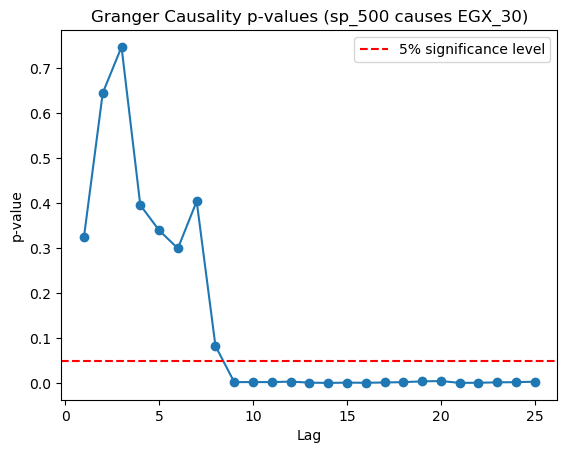

C:\Users\z004rwzm\AppData\Local\anaconda3\envs\my_pyspark_env\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


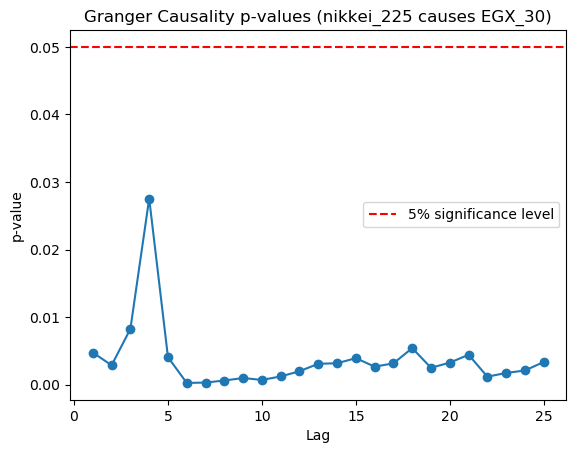

C:\Users\z004rwzm\AppData\Local\anaconda3\envs\my_pyspark_env\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


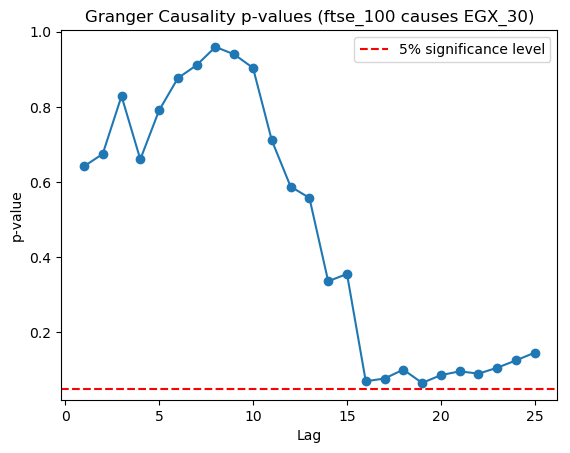

C:\Users\z004rwzm\AppData\Local\anaconda3\envs\my_pyspark_env\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


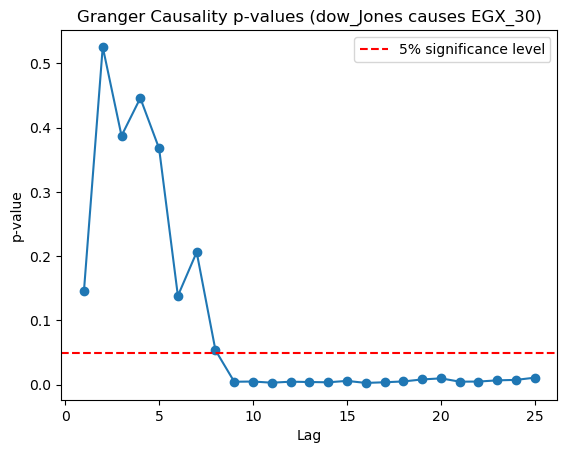

In [66]:
max_lag = 25

for index in indices:
    if "EGX" in index:
        continue
        
    gc_test_result = grangercausalitytests(daily_return_df[[f'{index}_daily_return', f'{Indices.EGX_30.name}_daily_return']], max_lag, verbose=False)

    lags = list(range(1, max_lag + 1))
    p_values = [gc_test_result[lag][0]['ssr_chi2test'][1] for lag in range(1, max_lag + 1)]
    
    plt.plot(lags, p_values, marker='o')
    plt.axhline(y=0.05, color='r', linestyle='--', label="5% significance level")
    plt.xlabel('Lag')
    plt.ylabel('p-value')
    plt.title(f"Granger Causality p-values ({index} causes EGX_30)")
    plt.legend()
    plt.show()


In [18]:
corr_mat = np.zeros((len(dfs), len(dfs)))
indices_ordered = []
for x, xdf in enumerate(dfs):
    indices_ordered.append(xdf)
    for y, ydf in enumerate(dfs):
        if y < x:
            continue
        elif y == x:
            corr_mat[x][y] = 1
        else:
            corr_mat[x,y] = merged_df_inner_join.stat.corr(f"scaled_{xdf}_{ColumnNames.Close.name}", f"scaled_{ydf}_{ColumnNames.Close.name}")
            corr_mat[y,x] = corr_mat[x,y]
            print(f"{xdf}_{ColumnNames.Close.name}", f"{ydf}_{ColumnNames.Close.name} , {corr_mat[x,y]}")

dow_Jones_Close ftse_100_Close , 0.7593578526181809
dow_Jones_Close nikkei_225_Close , 0.967142004987683
dow_Jones_Close sp_500_Close , 0.9929013010847094
dow_Jones_Close EGX_30_Close , -0.6071796480720932
ftse_100_Close nikkei_225_Close , 0.7844256990194346
ftse_100_Close sp_500_Close , 0.7228954344192607
ftse_100_Close EGX_30_Close , -0.3341866096332954
nikkei_225_Close sp_500_Close , 0.9655497097662474
nikkei_225_Close EGX_30_Close , -0.529863834149014
sp_500_Close EGX_30_Close , -0.6006613158076536


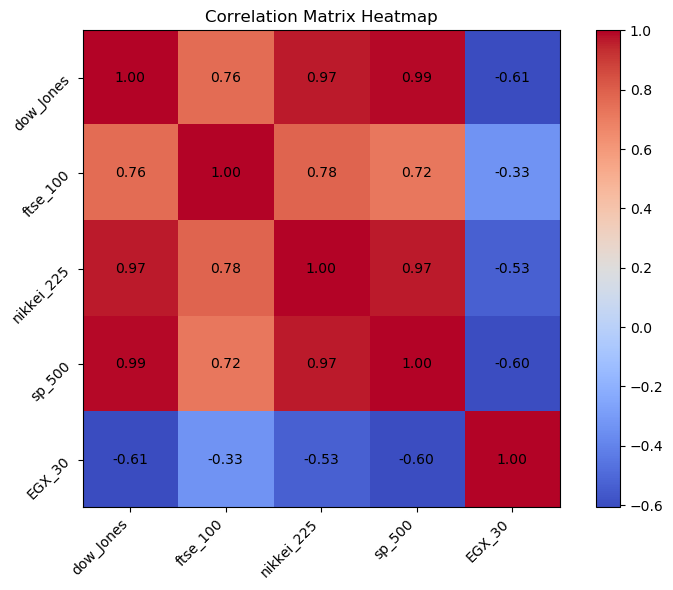

In [19]:
plt.figure(figsize=(8, 6))
heatmap = plt.imshow(corr_mat, cmap="coolwarm", interpolation="nearest")

plt.colorbar(heatmap)

plt.xticks(np.arange(len(indices_ordered)), indices_ordered, rotation=45, ha="right")
plt.yticks(np.arange(len(indices_ordered)), indices_ordered, rotation=45)

# Add annotations
for i in range(len(indices)):
    for j in range(len(indices)):
        plt.text(i, j, f"{corr_mat[i, j]:.2f}", ha="center", va="center", color="black")

# Title and layout
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

In [48]:
# for col in colNames:
#     summary = calculate_summary_stats(merged_df_inner_join,[col])
#     summary.show()

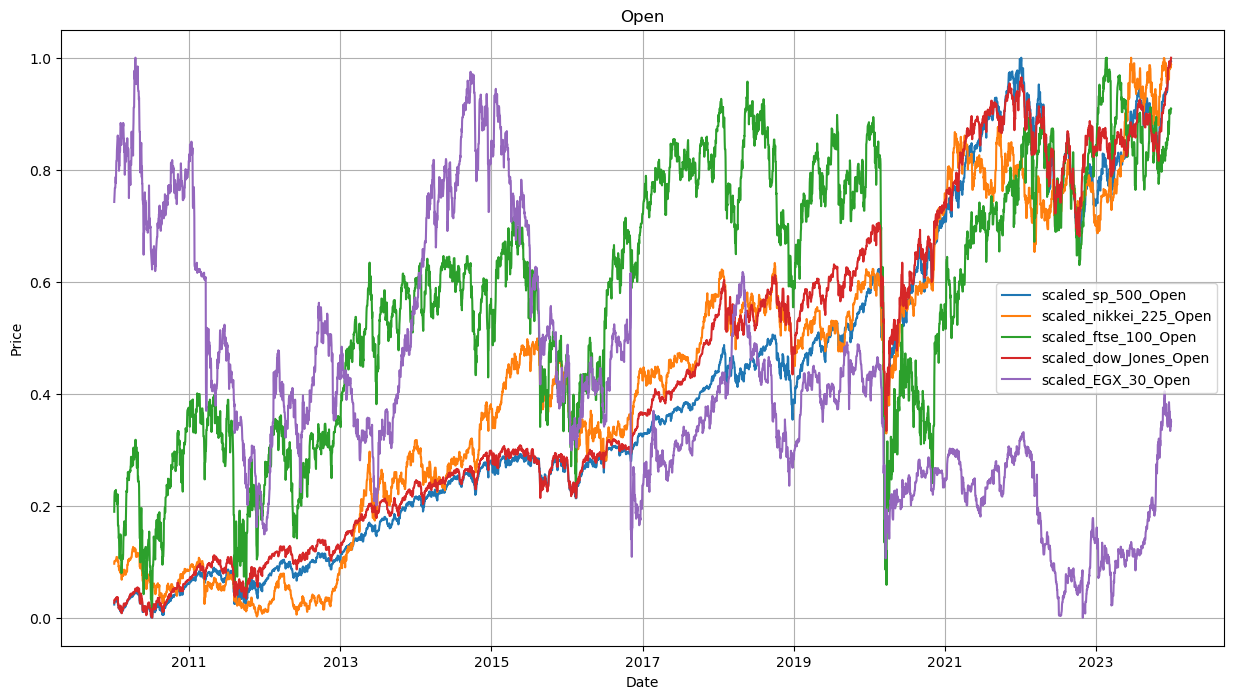

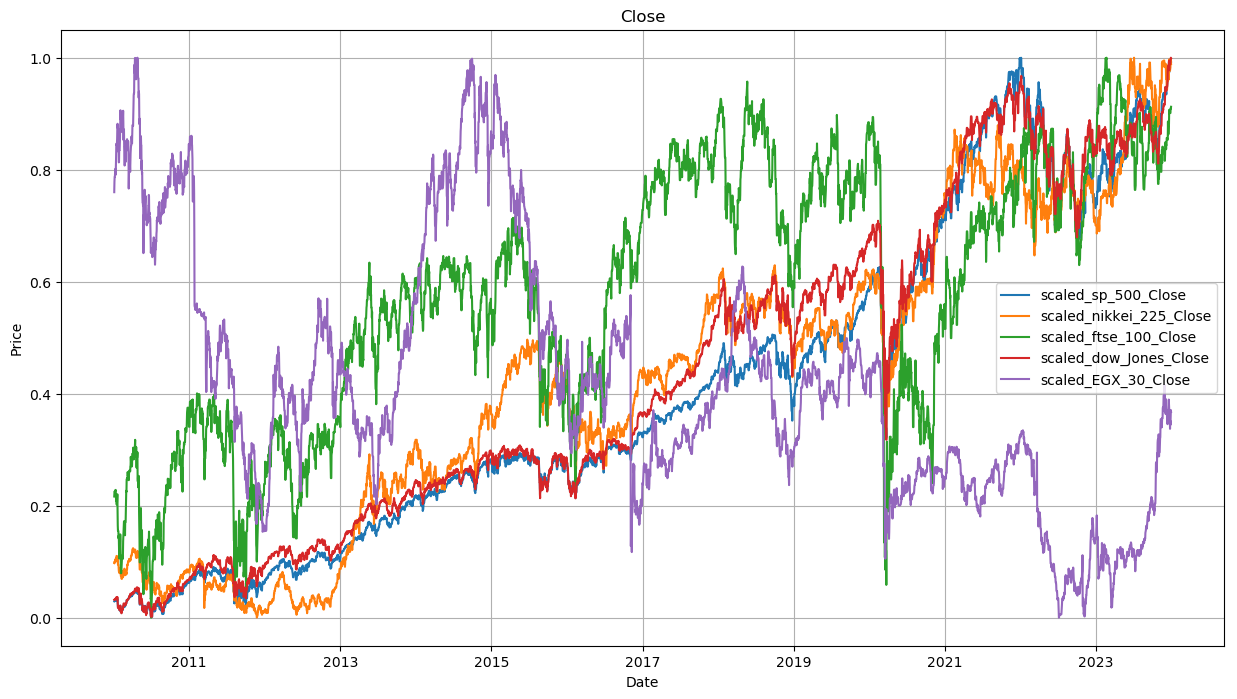

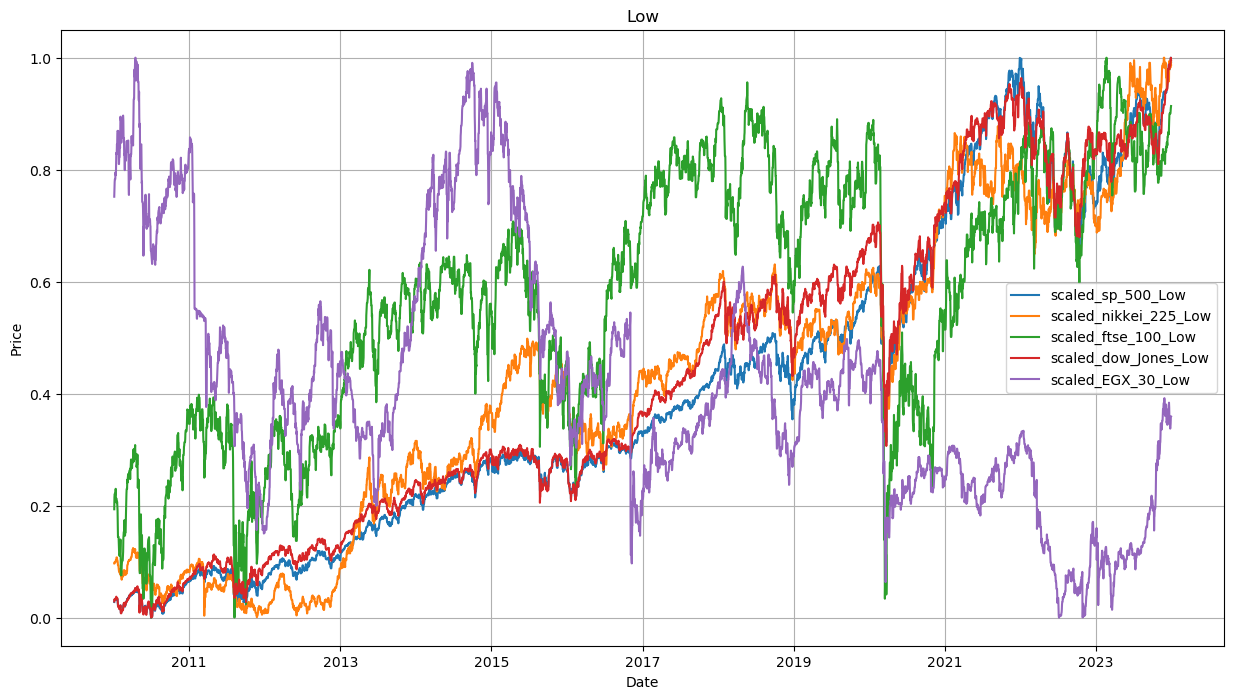

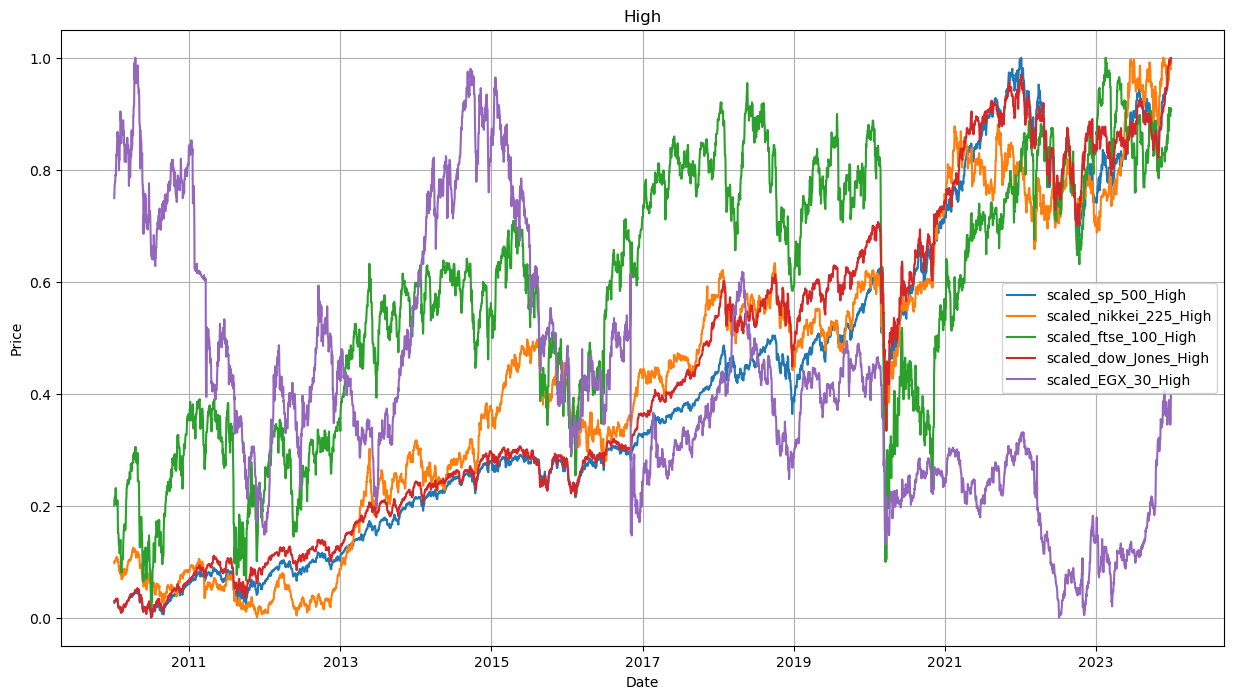

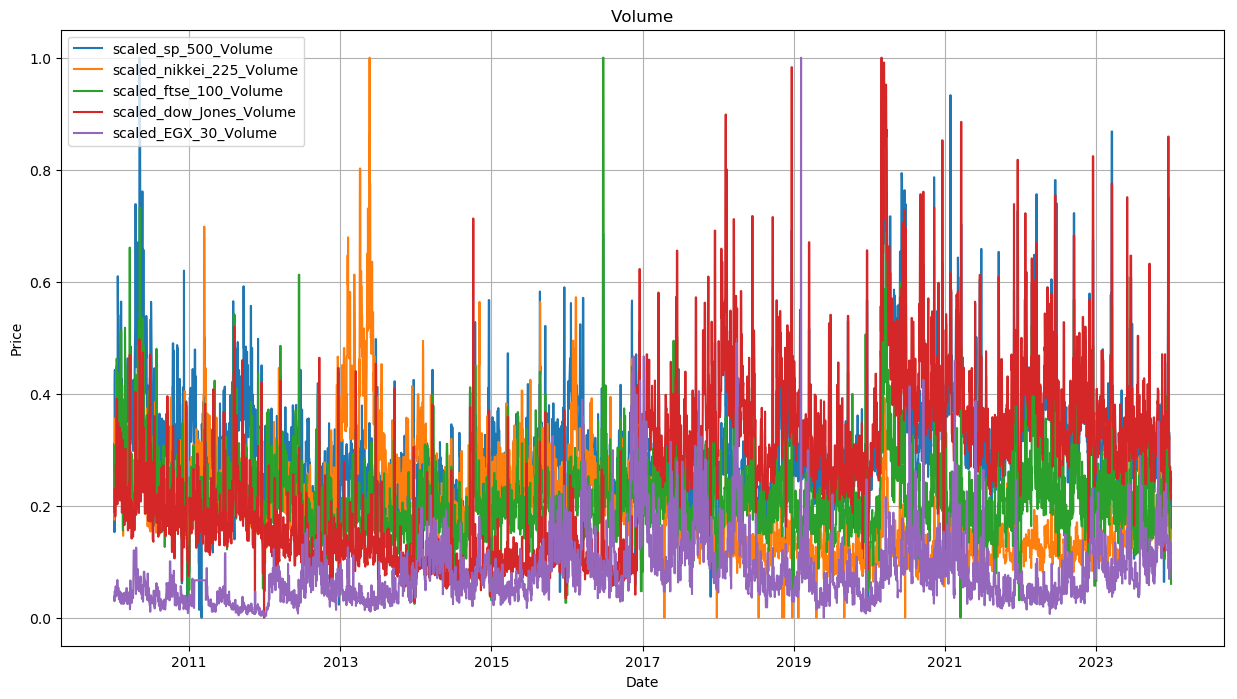

In [52]:
scaled_col_names = [f"scaled_{col_name}" for col_name in colNames]
pdf = merged_df_inner_join.select(["Date"] + scaled_col_names).orderBy("Date").toPandas().to_numpy()
for i in range(5):
    plot_numpy_array(
        data= pdf,
        column_names=["Date"] + scaled_col_names,
        date_col="Date",
        price_cols=[f"scaled_{colName}" for colName in colNames[i::5]],
        title=colNames[i::5][0].split("_")[-1]
    )

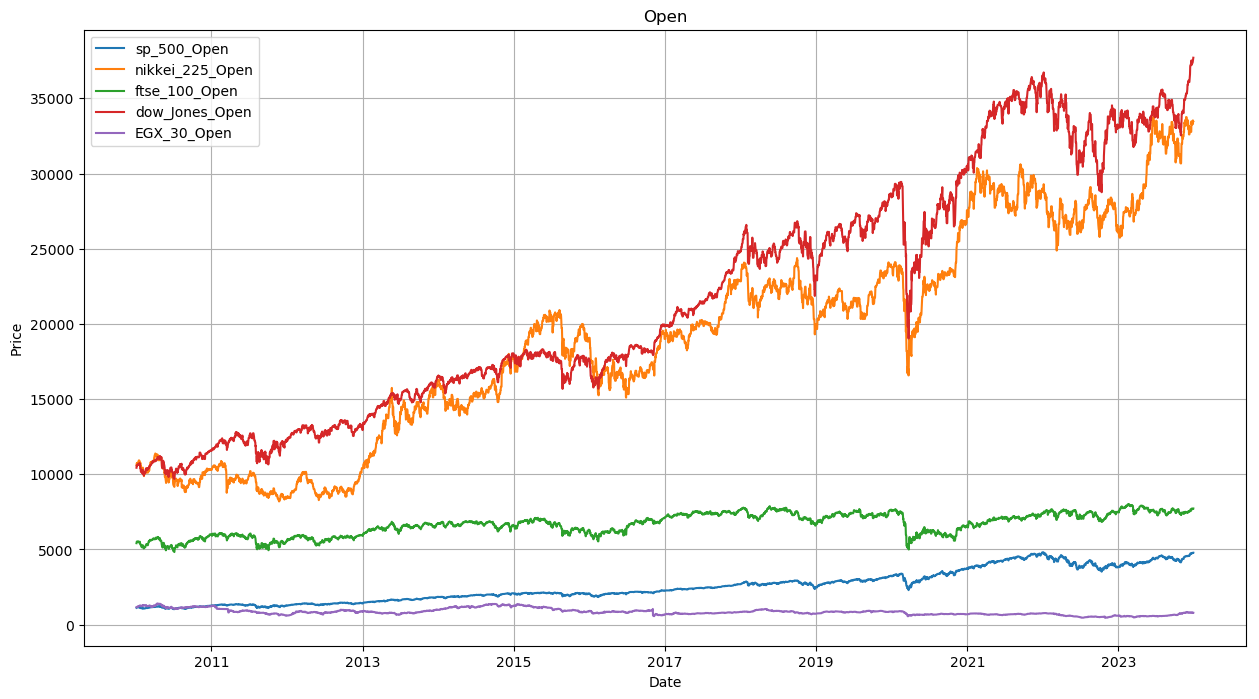

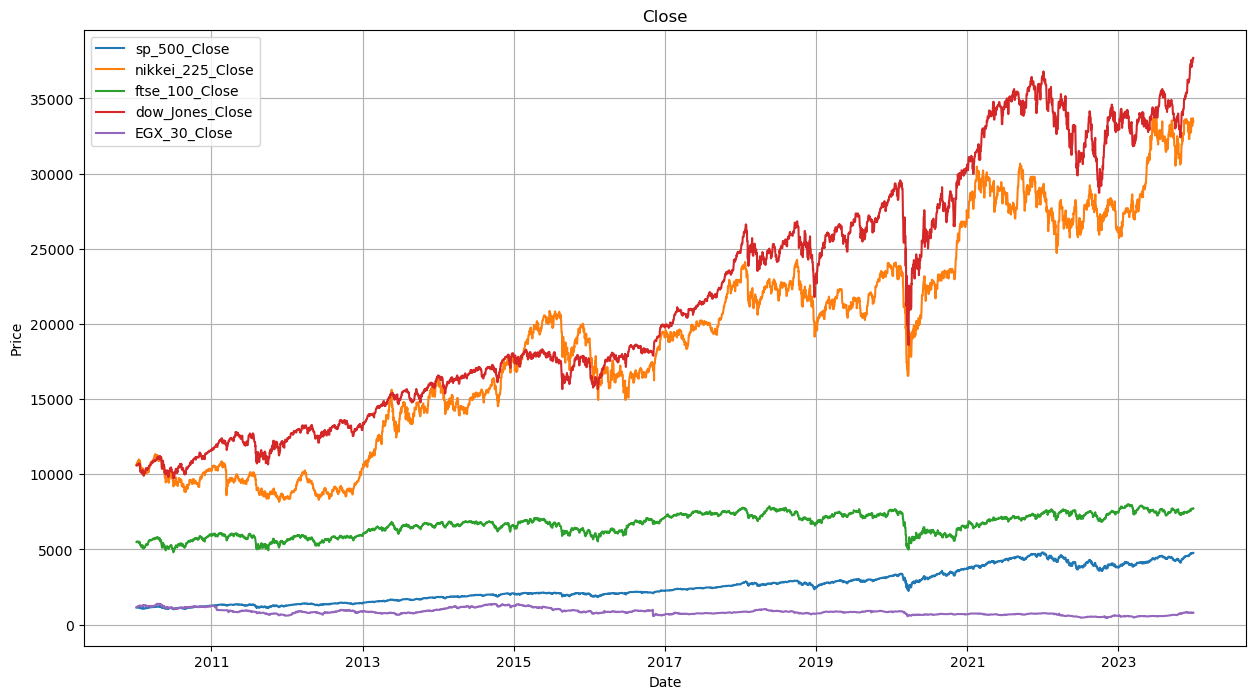

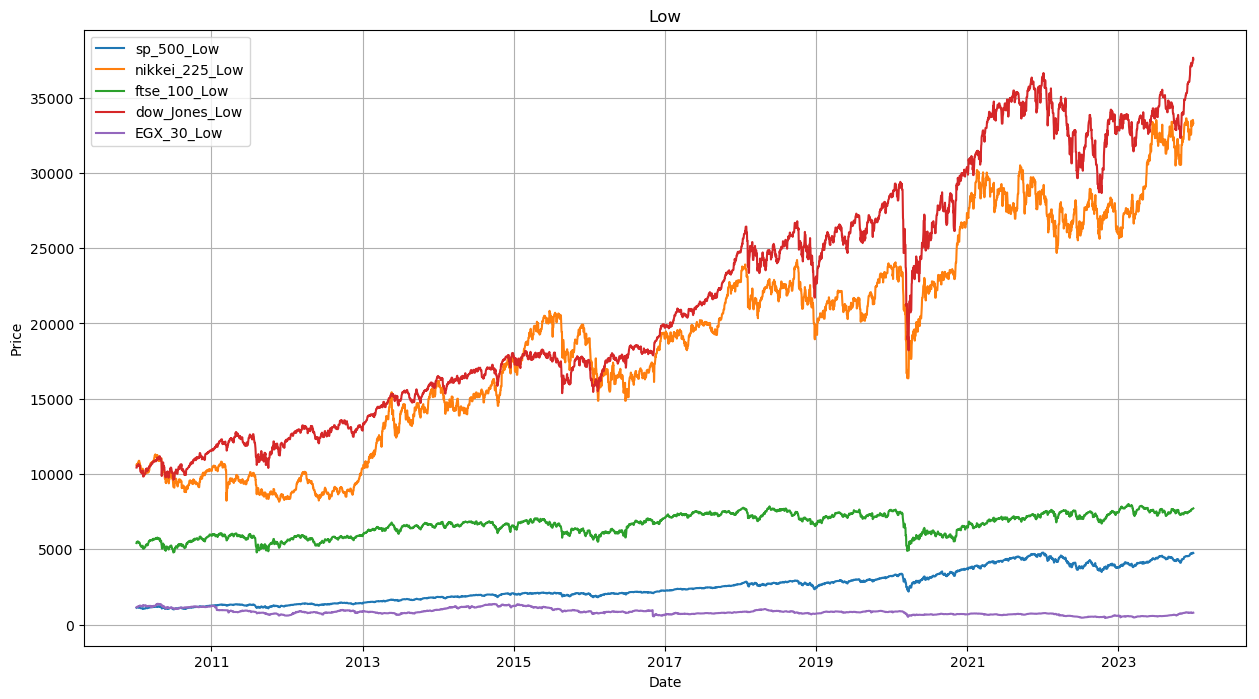

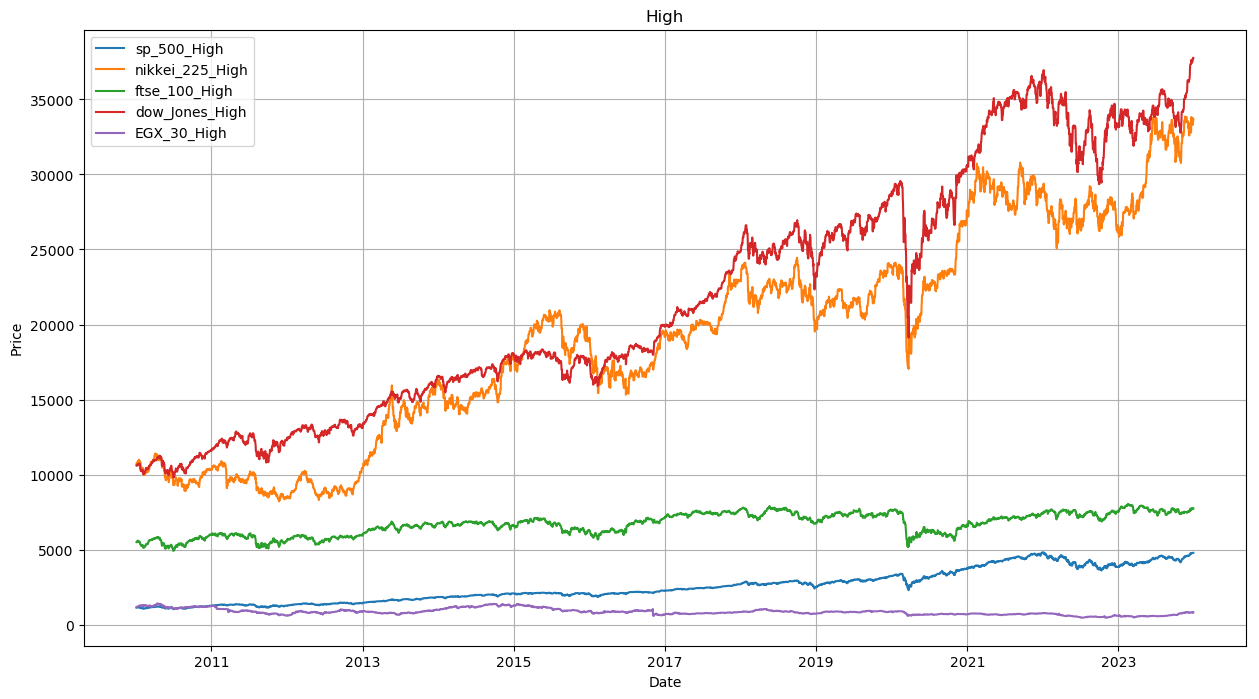

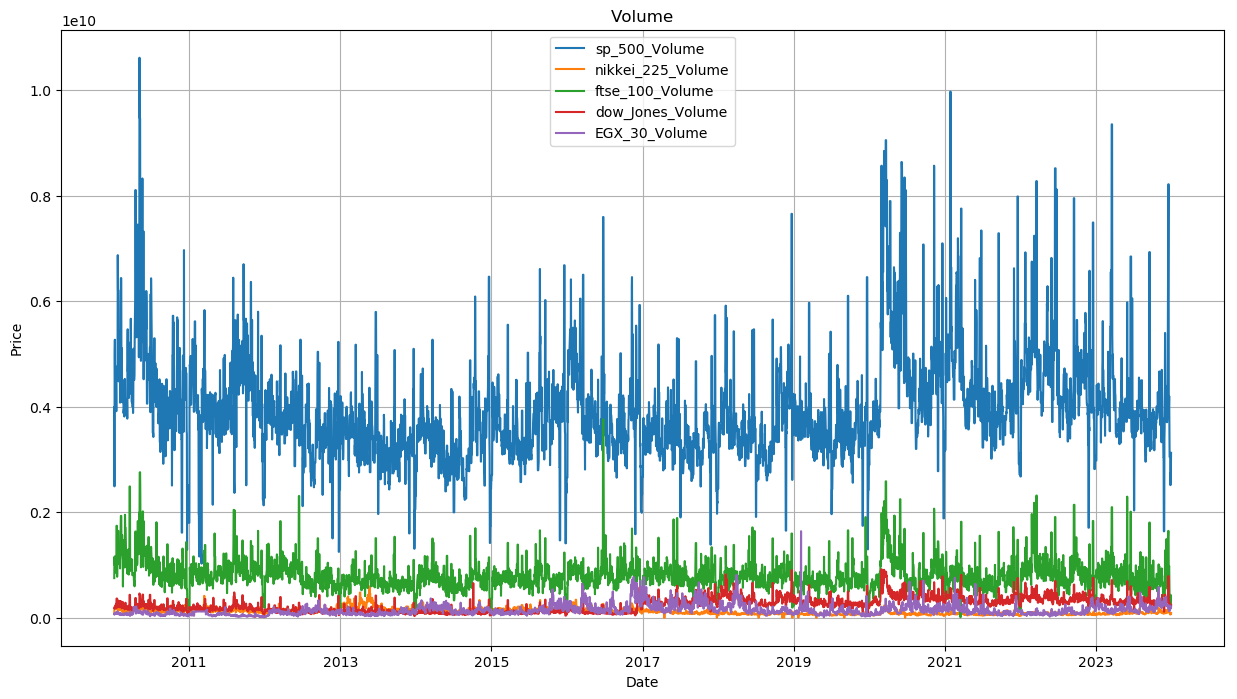

In [50]:
pdf = merged_df_inner_join.select(["Date"] + colNames).orderBy("Date").toPandas().to_numpy()
for i in range(5):
    plot_numpy_array(
        data= pdf,
        column_names=["Date"] + colNames,
        date_col="Date",
        price_cols=colNames[i::5],
        title=colNames[i::5][0].split("_")[-1]
    )

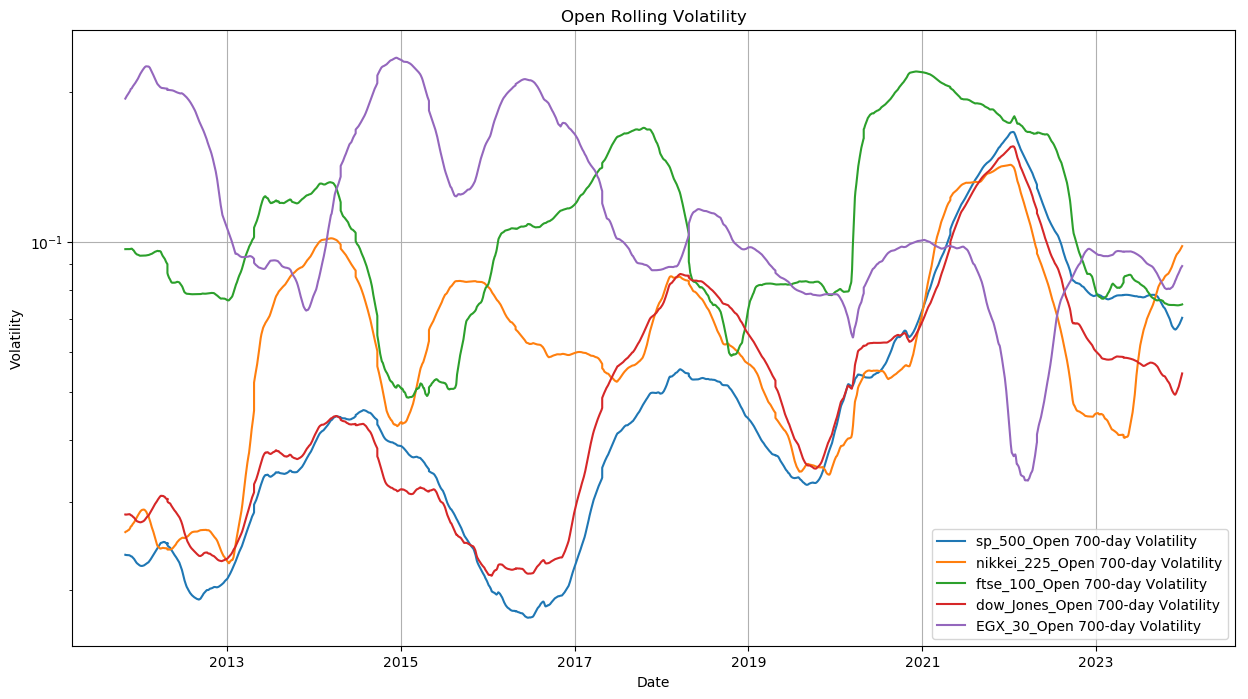

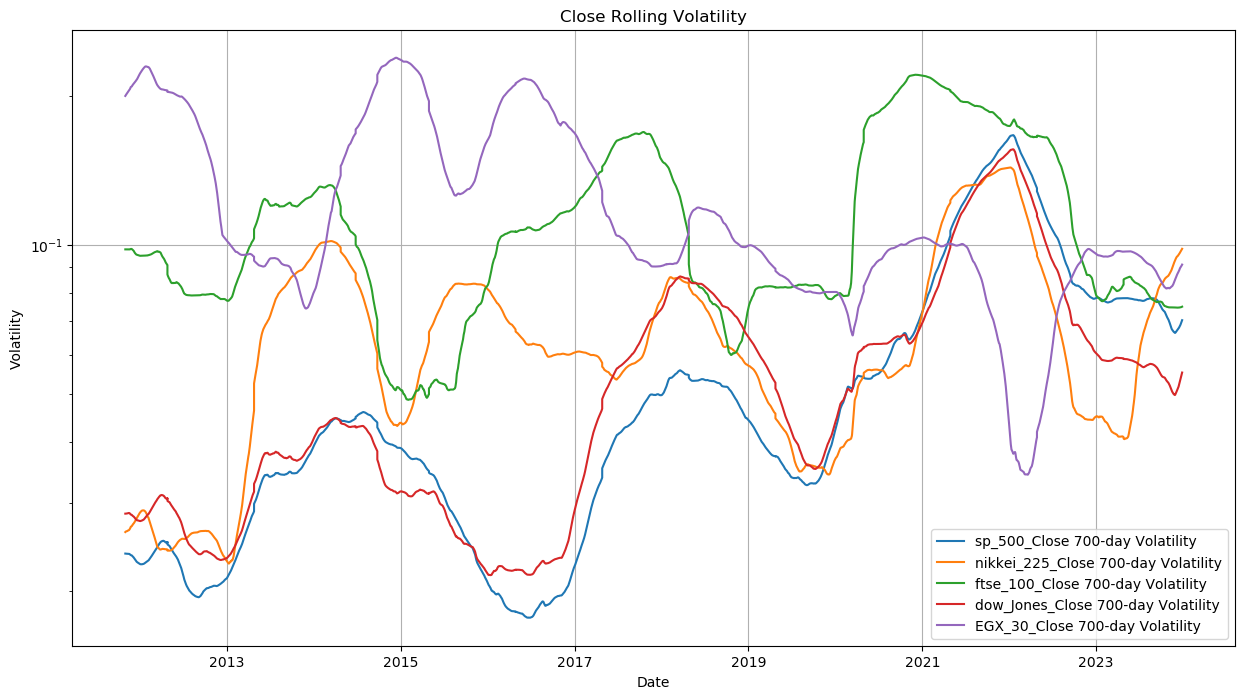

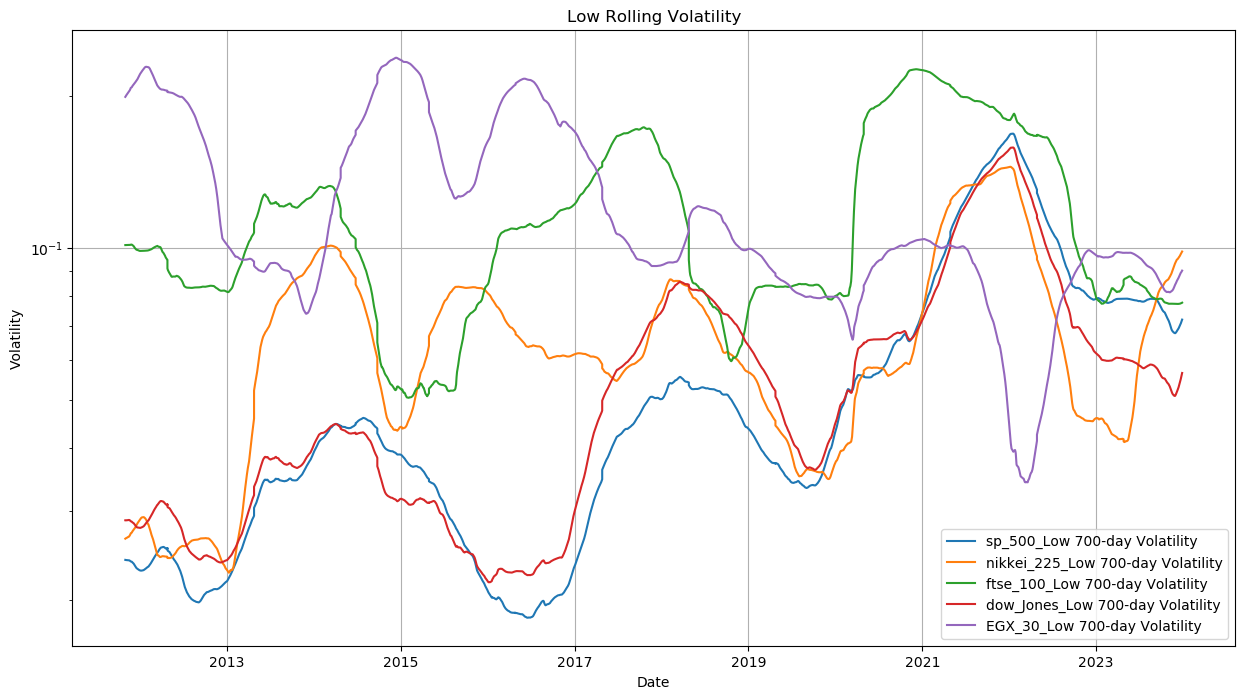

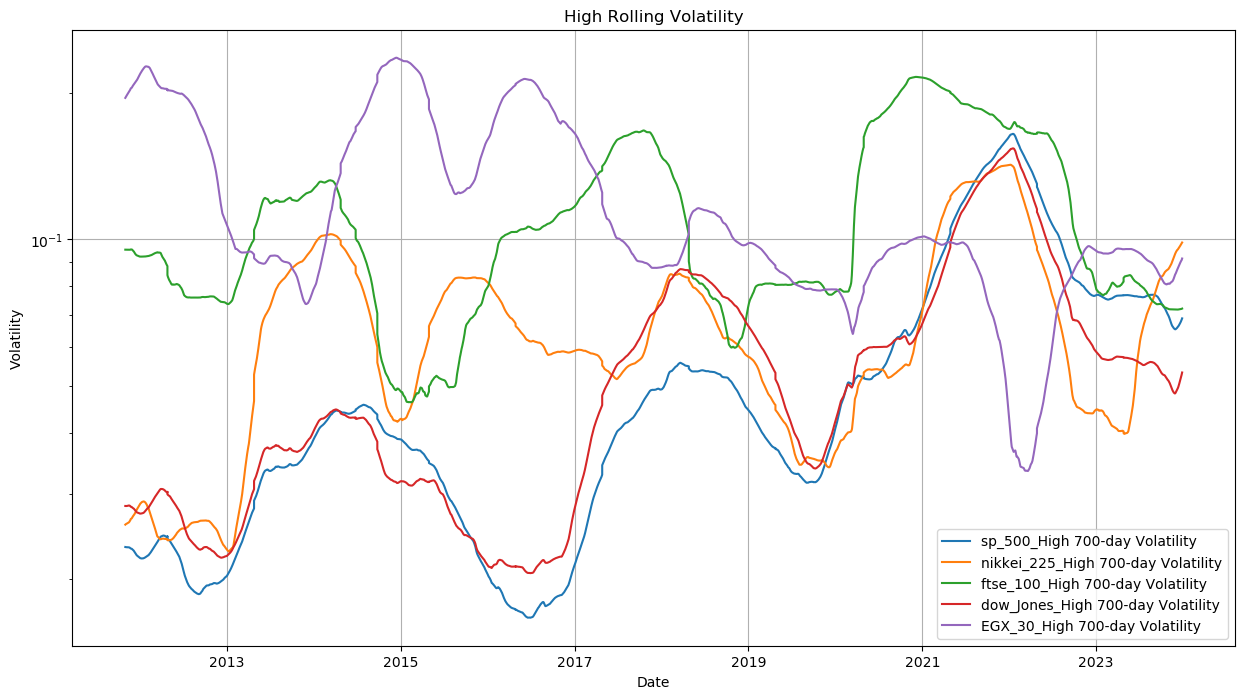

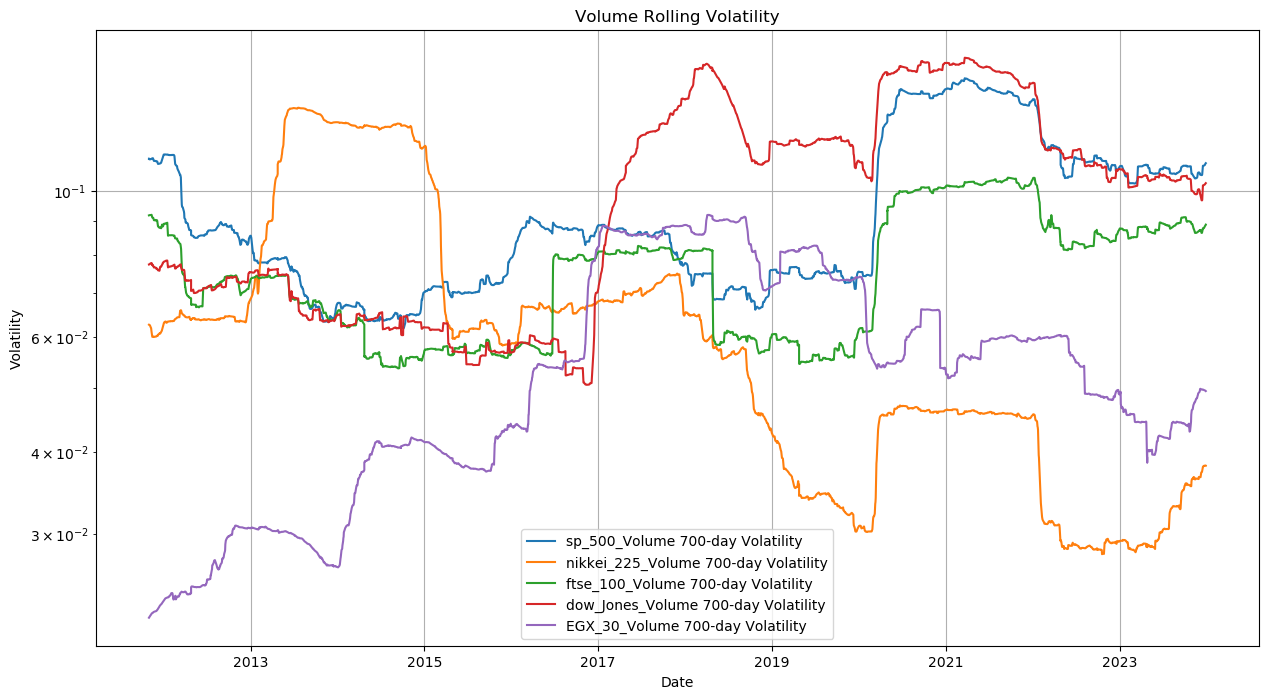

In [86]:
for i in range(5):
    plot_rolling_volatility(
        data=pdf,
        column_names=["Date"] + colNames,
        date_col="Date",
        price_cols=colNames[i::5],
        window=700,
        title= colNames[i::5][0].split("_")[-1] + " Rolling Volatility"
    )

In [106]:
from arch import arch_model

returns = daily_return_df['dow_Jones_daily_return']
model = arch_model(returns, vol='EGARCH', p=1, q=1, rescale = True)

garch_fit = model.fit(disp="off")
print(garch_fit.summary())

                       Constant Mean - EGARCH Model Results                       
Dep. Variable:     dow_Jones_daily_return   R-squared:                       0.000
Mean Model:                 Constant Mean   Adj. R-squared:                  0.000
Vol Model:                         EGARCH   Log-Likelihood:               -5687.34
Distribution:                      Normal   AIC:                           11382.7
Method:                Maximum Likelihood   BIC:                           11409.0
                                            No. Observations:                 5306
Date:                    Sat, Dec 14 2024   Df Residuals:                     5305
Time:                            15:48:21   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0681 

In [134]:
# Import necessary modules
from mvgarch.mgarch import DCCGARCH
from mvgarch.ugarch import UGARCH
import pandas as pd

# Assuming your dataset is already loaded as a DataFrame
# Replace 'path_to_your_csv' with the actual file path
returns = daily_return_df[1:]

returns = 300 * returns

# Ensure the DataFrame contains only the daily return columns
# Adjust the column names if necessary
returns = returns[[
    "dow_Jones_daily_return",
    "ftse_100_daily_return",
    "nikkei_225_daily_return",
    "sp_500_daily_return",
    "EGX_30_daily_return"
]]

for col in returns.columns:
    print(f"Fitting GARCH model for {col}...")
    asset = returns[col]
    garch = UGARCH(order=(1, 1))
    garch.spec(returns=asset)
    garch.fit()

n_tickers = returns.shape[1]  # Number of assets (columns)
garch_specs = [UGARCH(order=(1, 1)) for _ in range(n_tickers)]

# Initialize and fit the DCC-GARCH model
dcc = DCCGARCH()
dcc.spec(ugarch_objs=garch_specs, returns=returns)
dcc.fit()

n_ahead = 2
dcc_forecasts = dcc.forecast(n_ahead=n_ahead)

Fitting GARCH model for dow_Jones_daily_return...


C:\Users\z004rwzm\AppData\Local\anaconda3\envs\my_pyspark_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting GARCH model for ftse_100_daily_return...


C:\Users\z004rwzm\AppData\Local\anaconda3\envs\my_pyspark_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting GARCH model for nikkei_225_daily_return...


C:\Users\z004rwzm\AppData\Local\anaconda3\envs\my_pyspark_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting GARCH model for sp_500_daily_return...


C:\Users\z004rwzm\AppData\Local\anaconda3\envs\my_pyspark_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting GARCH model for EGX_30_daily_return...


C:\Users\z004rwzm\AppData\Local\anaconda3\envs\my_pyspark_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\z004rwzm\AppData\Local\anaconda3\envs\my_pyspark_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\z004rwzm\AppData\Local\anaconda3\envs\my_pyspark_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\z004rwzm\AppData\Local\anaconda3\envs\my_pyspark_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\z004rwzm\AppData\Local\anaconda3\envs\my_pyspark_en

In [136]:
# Access and print results
print("\nConditional Variances Forecasts:")
print(dcc_forecasts)

# print("\nConditional Correlations Forecasts:")
# print(dcc_forecasts['correlations'])  # Forecasted correlations

# import matplotlib.pyplot as plt

# conditional_corr = dcc.conditional_correlations

# dow_egx_corr = conditional_corr.loc[:, ("dow_Jones_daily_return", "EGX_30_daily_return")]
# plt.plot(dow_egx_corr.index, dow_egx_corr)
# plt.title("Time-Varying Correlation: Dow Jones vs EGX 30")
# plt.xlabel("Time")
# plt.ylabel("Correlation")
# plt.show()


Conditional Variances Forecasts:
None
